In [26]:
import math, random

def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ) :
    '''Start with the centre of the polygon at ctrX, ctrY, 
    then creates the polygon by sampling points on a circle around the centre. 
    Randon noise is added by varying the angular spacing between sequential points,
    and by varying the radial distance of each point from the centre.

    Params:
    ctrX, ctrY - coordinates of the "centre" of the polygon
    aveRadius - in px, the average radius of this polygon, this roughly controls how large the polygon is, really only useful for order of magnitude.
    irregularity - [0,1] indicating how much variance there is in the angular spacing of vertices. [0,1] will map to [0, 2pi/numberOfVerts]
    spikeyness - [0,1] indicating how much variance there is in each vertex from the circle of radius aveRadius. [0,1] will map to [0, aveRadius]
    numVerts - self-explanatory

    Returns a list of vertices, in CCW order.
    '''

    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]
    points.append(points[0])
    return points

def clip(x, min, max) :
     if( min > max ) :  return x    
     elif( x < min ) :  return min
     elif( x > max ) :  return max
     else :             return x

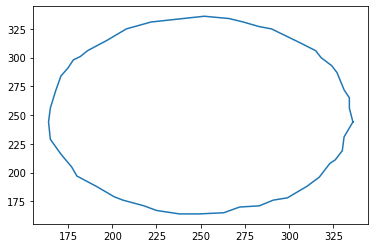

In [44]:
import numpy as np

verts = np.array(generatePolygon( ctrX=250, ctrY=250, 
                                 aveRadius=np.random.random()*100, 
                                 irregularity=.6, 
                                 spikeyness=0.01, 
                                 numVerts=50 ))
plt.plot(verts[:,0],verts[:,1])

# verts = np.array(generatePolygon( ctrX=50, ctrY=250, aveRadius=np.random.random()*100, irregularity=10.6, spikeyness=0.1, numVerts=16 ))
# plt.plot(verts[:,0],verts[:,1])

# verts = np.array(generatePolygon( ctrX=450, ctrY=250, aveRadius=np.random.random()*100, irregularity=1.6, spikeyness=0.1, numVerts=16 ))
# plt.plot(verts[:,0],verts[:,1])

# verts = np.array(generatePolygon( ctrX=250, ctrY=50, aveRadius=np.random.random()*100, irregularity=0.6, spikeyness=0.1, numVerts=16 ))
# plt.plot(verts[:,0],verts[:,1])

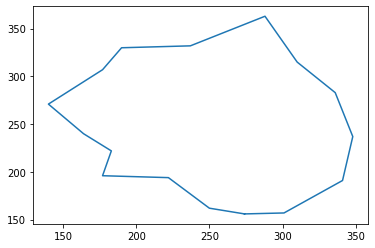

In [29]:
plt.plot(verts[:,0],verts[:,1])

In [46]:
import sys, os
import mplstereonet
import scipy
import scipy.fftpack
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

'''Generate isotropic fractal surface image using
spectral synthesis method [1, p.]
References:
1. Yuval Fisher, Michael McGuire,
The Science of Fractal Images, 1988

(cf. http://shortrecipes.blogspot.com.au/2008/11/python-isotropic-fractal-surface.html)
**Arguments**:
 -fd = the fractal dimension
 -N = the size of the fractal surface/image
     
'''
def fractalGrid(fd=2.5, N=256):
    H=1-(fd-2);
    X=np.zeros((N,N),complex)
    A=np.zeros((N,N),complex)
    powerr=-(H+1.0)/2.0

    for i in range(int(N/2)+1):
        for j in range(int(N/2)+1):
            phase=2*np.pi*np.random.rand()

            if i is not 0 or j is not 0:
                rad=(i*i+j*j)**powerr*np.random.normal()
            else:
                rad=0.0

            A[i,j]=complex(rad*np.cos(phase),rad*np.sin(phase))

            if i is 0:
                i0=0
            else:
                i0=N-i

            if j is 0:
                j0=0
            else:
                j0=N-j

            A[i0,j0]=complex(rad*np.cos(phase),-rad*np.sin(phase))

            A.imag[int(N/2)][0]=0.0
            A.imag[0,int(N/2)]=0.0
            A.imag[int(N/2)][int(N/2)]=0.0

    for i in range(1,int(N/2)):
        for j in range(1,int(N/2)):
            phase=2*np.pi*np.random.rand()
            rad=(i*i+j*j)**powerr*np.random.normal()
            A[i,N-j]=complex(rad*np.cos(phase),rad*np.sin(phase))
            A[N-i,j]=complex(rad*np.cos(phase),-rad*np.sin(phase))

    itemp=scipy.fftpack.ifft2(A)
    itemp=itemp-itemp.min()
    
    return itemp.real/itemp.real.max()

"""
Display a grid matplotlibs imshow function
"""
def draw(grid): 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    CM = ax.imshow(grid, cmap="Greys_r")
    fig.colorbar(CM)
    return fig

#utitlity function for plotting grids
def plotGrids(titles, grid, values):
    """
    Plots a list of values on a gridded stereonets. The grid is 
    is expected to be a complete hemisphere in lat/long coordinates.
    """
        
    nAxes = len(values) #number of axes to draw
    bound = np.pi / 2 #boundaries of the stereonet hemisphere
    minV = 99999999999999999 #min for color ramp
    maxV = -9999999999999999 #max for color ramp
    
    patches = [] #list of patch objects for each grid
    for i in range(len(values)):
        
        #build patches for this grid
        patches.append([])
        
        #loop through points in grid and create patch objects
        for _lat,_lon in grid.T:
            patches[i].append(mpl.patches.Circle( (_lon, _lat), .02)) #store "dot" for plotting
        
        #check minV and maxV
        if np.min(values[i]) < minV:
            minV = np.min(values[i])
        if np.max(values[i]) > maxV:
            maxV = np.max(values[i])
    
    #init figure
    fig = plt.figure(figsize=(8 * nAxes, 8))
    
    #build throw-away axes to get color-ramp object
    cmap_name = "coolwarm" #plasma
    ax = fig.add_subplot(111, projection='stereonet')
    x = np.linspace(minV,maxV)
    y = np.linspace(minV,maxV)
    CS3 = ax.scatter(x,y,c=x, cmap=cmap_name)
    fig.clf()
    
    #create normalization object for color-mapping
    #now create colour map
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=minV,vmax=maxV) 

    #build axes
    for i in range(nAxes):
        pos = "1%d%d" % (nAxes,i+1)
        ax = fig.add_subplot(pos, projection='stereonet')
        ax.set_title(titles[i],y=1.08)
        
        #reshape grid for matplotlib contourf
        res = int(np.sqrt(len(values[i])))
        assert res**2 == len(values[i]), "Error: values must be sampled from a square grid."
        vals = np.reshape(values[i],(res,res)).T

        #push contour points
        bound = np.pi / 2
        ax.contourf(np.linspace(-bound,bound,res),np.linspace(-bound,bound,res), vals,cmap="coolwarm")
        
    #finally, add the color-ramp
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    fig.colorbar(CS3, cax=cbar_ax)
    
    return fig

c:\users\lgrose\.conda\envs\loop\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


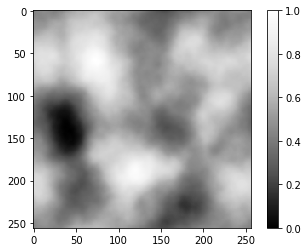

c:\users\lgrose\.conda\envs\loop\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """
c:\users\lgrose\.conda\envs\loop\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


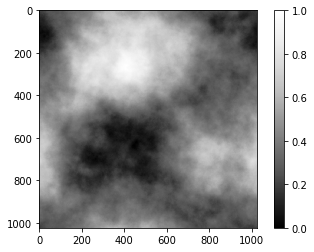

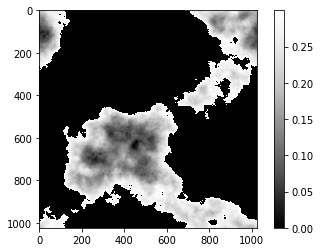

In [78]:
#build topography
topo = fractalGrid(2.1,1024)

fig = draw(topo)
fig.show()
t = .3
topo_masked = np.zeros(topo.shape)
topo_masked[topo<t] = topo[topo<t]
fig = draw(topo_masked)
fig.show()

c:\users\lgrose\.conda\envs\loop\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


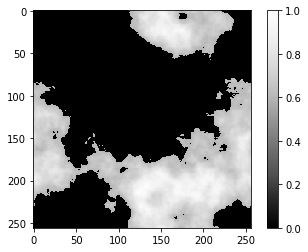